In [1]:
import torch.nn as nn
import torch
import os
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mpl_toolkits.axes_grid1 import ImageGrid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_folder = r'img_align_celeba'

for _, _, files in os.walk(data_folder):
    files = files
im_file = files[11]
img_shape = (32, 32, 3)
img = load_img(os.path.join(data_folder, im_file), target_size=img_shape[:2])
img = img_to_array(img).reshape(3,32,32)/255.

202599
(3, 32, 32)


In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128*8*8),
            nn.ReLU()      
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2 ,  stride=2 , bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 1,1),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2 ,  stride=2 , bias=False),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, 1,1),          
            nn.Sigmoid()
        
        
        )


    def forward(self, x):
            x = self.linear_layers(x)  
            x = x.view(-1,128,8,8)
            return self.conv_layers(x)
        
        

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            self._cnn_block(in_channels=3, out_channels=32, kernel_size=3, stride=2),
            self._cnn_block(32, 64, 3, 2),
            self._cnn_block(64, 128, 3, 1),
            nn.Flatten()
        )
        
        self.linear_layers = nn.Sequential(nn.Linear(6272,1024),
                                           nn.ReLU(),
                                           nn.Linear(1024,1),
                                           nn.Sigmoid())
        
        
    def _cnn_block(self, in_channels, out_channels, kernel_size, stride):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=stride)
        
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

In [6]:
z_dim = 400
lr = 7e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = Generator(z_dim).to(device)
optimizer = torch.optim.Adam(list(gen.parameters()), lr = lr, betas=(0.5, 0.999))

batch_size = 128

discr = Discriminator().to(device)
optimizer2 = torch.optim.Adam(discr.parameters(), lr = lr, betas=(0.5, 0.999))
eps = 1e-6

In [7]:
def ms_criterion(noise, noise2, fake, fake2):
    return 1/(torch.mean(torch.abs(fake - fake2)) / torch.mean(torch.abs(noise - noise2)) + 1e-5)

In [8]:
def get_x_batch(batch_size):
    imgs = []
    for _ in range(batch_size):
        rand_no = int(len(files) * np.random.rand(1))
        x = load_img(os.path.join(data_folder, files[rand_no]), target_size=img_shape[:2])
        x = img_to_array(x).reshape(3,32,32)/255.
        imgs += [x]
    return torch.tensor(imgs, dtype=torch.float32)

In [19]:
def train():
    for i in range(5):   
        x = get_x_batch(batch_size)    
        z = torch.randn((batch_size,z_dim))
        z2 = torch.randn((batch_size,z_dim))

        loss = 0
        out_for = gen(z)
        
        out_for2 = gen(z2)

        disc_fake = discr(out_for)
        loss_gen = -torch.mean(torch.log(disc_fake + 1e-10)) + 1* ms_criterion(z, z2, out_for, out_for2)

        optimizer.zero_grad()
        loss_gen.backward()
        optimizer.step()
        
        for p in range(1):
            x = get_x_batch(batch_size)        
            z = torch.randn((batch_size,z_dim))            
            out_for = gen(z)

            disc_real = discr(x)
            disc_fake = discr(out_for)
            loss_disc = -torch.mean(torch.log(disc_real + 1e-10) + torch.log(1 - disc_fake + 1e-10))
            optimizer2.zero_grad()

            loss_disc.backward()
            optimizer2.step()

    return loss

In [20]:
for i in range(500000000):
    train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

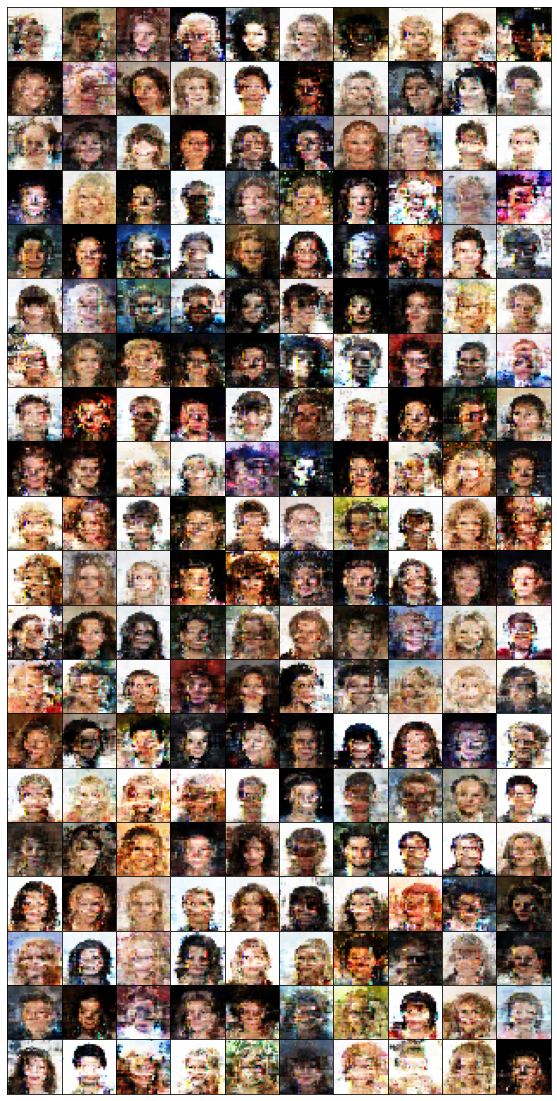

In [29]:
gene = gen.eval()
bs = 200

plt.figure()
with torch.no_grad():
    z = torch.randn((bs,z_dim))
    out_for = gene(z).cpu().data.numpy()
    
    out_for1 = []
    for i in range(20):
            for j in range(10):
                out_for1 += [out_for[10*i+j].reshape(3,32,32).reshape(32,32,3)]
    fig = plt.figure(figsize=(20, 20))

    grid = ImageGrid(fig,111, 
                 nrows_ncols=(20, 10),  
                 axes_pad=0,  
                 )
    for ax, im in zip(grid, out_for1):
        ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False)
        ax.imshow(im)
    plt.savefig('gen_celeba_tight1.png', bbox_inches='tight')
    plt.show()